# SurvSHAP vs DeepLift vs Integrated Gradients
### J. Krajewski, S. Frejlak, M. Wojtala

### Experiment 1: evaluation on artificial datsa

#### Imports

In [ ]:
!pip3 install torchtuples
!pip3 install pycox

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
from scipy.integrate import trapezoid

import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks
import torchtuples as tt # Some useful functions

from pycox.models import DeepHitSingle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 647 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 2.5 MB/s 
     |████████████████████████████████| 65 kB 4.2 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
     |████████████████████████████████| 139 kB 71.6 MB/s 
     |████████████████████████████████| 378 kB 76.7 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 2.3 MB 29.2 MB/s 
     |████████████████████████████████| 357 kB 62.1 MB/s 


The next part of experiment 1 will be here after overcoming technical difficulties...

### Experiment 2: Real-world use case: predicting survival of patients with heart failure

#### Preparing data and deep model

In [4]:
df_train = pd.read_csv('sample_data/exp3_heart_failure_dataset.csv')
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
10,75.0,1,81,0,38,1,368000.00,4.0,131,1,1,10,1


In [5]:
cols_standardize = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
cols_leave = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
num_durations = 10

labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['time'].values, df['DEATH_EVENT'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

x_train.transpose()

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

#### Training deep model

In [175]:
in_features = x_train.shape[1]
num_nodes = [4, 4]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.0

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [176]:
model = DeepHitSingle(net, tt.optim.Adam(0.0001), duration_index=labtrans.cuts)

In [177]:
batch_size = 32
epochs = 1000
callbacks = []# [tt.cb.EarlyStopping()]

In [178]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.4945,	val_loss: 0.4729
1:	[0s / 0s],		train_loss: 0.5011,	val_loss: 0.4816
2:	[0s / 0s],		train_loss: 0.4938,	val_loss: 0.4852
3:	[0s / 0s],		train_loss: 0.4836,	val_loss: 0.4947
4:	[0s / 0s],		train_loss: 0.4933,	val_loss: 0.5029
5:	[0s / 0s],		train_loss: 0.4734,	val_loss: 0.5044
6:	[0s / 0s],		train_loss: 0.4918,	val_loss: 0.5123
7:	[0s / 0s],		train_loss: 0.5104,	val_loss: 0.5134
8:	[0s / 0s],		train_loss: 0.4904,	val_loss: 0.5146
9:	[0s / 0s],		train_loss: 0.4664,	val_loss: 0.5150
10:	[0s / 0s],		train_loss: 0.4741,	val_loss: 0.5150
11:	[0s / 0s],		train_loss: 0.4860,	val_loss: 0.5164
12:	[0s / 0s],		train_loss: 0.4623,	val_loss: 0.5126
13:	[0s / 0s],		train_loss: 0.4731,	val_loss: 0.5111
14:	[0s / 0s],		train_loss: 0.4807,	val_loss: 0.5088
15:	[0s / 0s],		train_loss: 0.4704,	val_loss: 0.5021
16:	[0s / 0s],		train_loss: 0.4813,	val_loss: 0.5042
17:	[0s / 0s],		train_loss: 0.4663,	val_loss: 0.5037
18:	[0s / 0s],		train_loss: 0.4742,	val_loss: 0.5039
19:

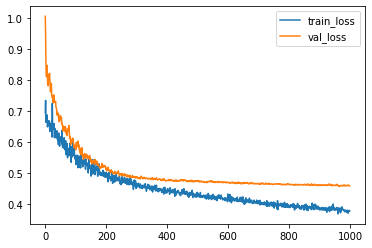

In [174]:
_ = log.plot()

#### Preparing data and non-deep models 

In [ ]:
real_data = pd.read_csv("data/exp3_heart_failure_dataset.csv")
real_data.rename(columns={"DEATH_EVENT": "event"}, inplace=True)

In [ ]:
from sksurv.util import Surv
X = real_data[["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", 
                "serum_creatinine", "serum_sodium", "sex", "smoking"]]
y = Surv.from_dataframe("event", "time", real_data)

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
rsf = RandomSurvivalForest(random_state=42, n_estimators=120, max_depth=8, min_samples_leaf=4, max_features=3)
rsf.fit(X, y)
rsf.score(X, y)

0.8758763084605781

#### Creating explanations

In [ ]:
from survshap import SurvivalModelExplainer, ModelSurvSHAP
from survlime import SurvLIME
rsf_exp = SurvivalModelExplainer(rsf, X, y)

In [ ]:
exp3_survshap_global_rsf = ModelSurvSHAP(random_state=42)
exp3_survshap_global_rsf.fit(rsf_exp)

100%|██████████| 299/299 [32:46<00:00,  6.58s/it]


In [ ]:
with open("pickles/exp3_survshap_global_rsf", "wb") as f:
    pickle.dump(exp3_survshap_global_rsf, f)

In [ ]:
n_obs = len(X)
sls = [None for i in range(n_obs)]
funcs_dist = [None for i in range(n_obs)]
for i in tqdm(range(n_obs)):
    survlime = SurvLIME(N=1000)
    survlime.fit(rsf_exp, X.iloc[[i]], k=2, timestamps=rsf.predict_survival_function(X.iloc[[0]])[0].x)
    sls[i] = survlime

100%|██████████| 299/299 [04:00<00:00,  1.24it/s]


In [ ]:
with open("pickles/exp3_survlime_global_rsf", "wb") as f:
    pickle.dump(sls, f)

#### Results analysis

In [ ]:
with open("pickles/exp3_survshap_global_rsf", "rb") as f:
    exp3_survshap_global_rsf = pickle.load(f)

In [ ]:
with open("pickles/exp3_survlime_global_rsf", "rb") as f:
    exp3_survlime_global_rsf = pickle.load(f)

##### Plot examples

In [ ]:
example_rsf = exp3_survshap_global_rsf.individual_explanations[12]

In [ ]:
melted_example_rsf = pd.melt(example_rsf.result, id_vars="variable_name", value_vars=example_rsf.result.columns[6:])
melted_example_rsf["variable"] = melted_example_rsf["variable"].str[4:].astype(float)
melted_example_rsf.to_csv("results/exp3_example_rsf.csv", index=False)
example_rsf.simplified_result.to_csv("results/exp3_example_rsf_agg.csv", index=False)

In [ ]:
example_rsf2 = exp3_survshap_global_rsf.individual_explanations[14]
melted_example_rsf_2 = pd.melt(example_rsf2.result, id_vars="variable_name", value_vars=example_rsf2.result.columns[6:])
melted_example_rsf_2["variable"] = melted_example_rsf_2["variable"].str[4:].astype(float)
melted_example_rsf_2.to_csv("results/exp3_example_rsf_2.csv", index=False)

##### Importance rankings

In [ ]:
def get_orderings_and_ranks_shap(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result.copy()
        df["aggregated_change"] = trapezoid(np.abs(df.iloc[:, 6:].values), explanation.timestamps)
        importance_orderings.append(df.sort_values(by="aggregated_change", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.aggregated_change).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

from scipy.stats import weightedtau
def mean_weighted_tau(ranks1, ranks2):
    taus = [None] * 100
    for i in range(100):
        tau, _ = weightedtau(ranks1.iloc[i], ranks2.iloc[i])
        taus[i] = tau
    return np.mean(taus), np.std(taus)

def prepare_ranking_summary_long(ordering):
    res = pd.DataFrame(columns=[0, 1, 2, 3, 4, 5, 6, 7])
    for i in range(8):
        tmp = pd.DataFrame(ordering[i].value_counts().to_dict(), index=[i+1])
        res = pd.concat([res, tmp])
    res = res.reset_index().rename(columns=dict(zip([i for i in range(8)] + ["index"], X.columns.to_list() + ["importance_ranking"])))
    return res.melt(id_vars=["importance_ranking"], value_vars=X.columns)

In [ ]:
def get_orderings_and_ranks_shap(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result.copy()
        df["aggregated_change"] = trapezoid(np.abs(df.iloc[:, 6:].values), explanation.timestamps)
        importance_orderings.append(df.sort_values(by="aggregated_change", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.aggregated_change).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

def get_orderings_and_ranks_lime(explanations):
    importance_orderings = []
    importance_ranks = []
    for explanation in explanations:
        df = explanation.result
        df["impact"] = df["variable_value"] * df["coefficient"] 
        importance_orderings.append(df.sort_values(by="impact", key=lambda x: -abs(x)).index.to_list())
        importance_ranks.append(np.abs(df.impact).rank(ascending=False).to_list())
    return pd.DataFrame(importance_orderings), pd.DataFrame(importance_ranks)

In [ ]:
rsf_survshap_orderings, rsf_survshap_ranks = get_orderings_and_ranks_shap(exp3_survshap_global_rsf.individual_explanations)
prepare_ranking_summary_long(rsf_survshap_orderings).to_csv("results/exp3_survshap_orderings_rsf.csv")

#### Calculating permutational variable importance

In [ ]:
from sksurv.metrics import brier_score, integrated_brier_score
# mask created to enable for calculating Brier score
mask = (y["time"] < y[y["event"]==1]["time"].max()) & (y["time"] > y[y["event"]==1]["time"].min())
times = np.unique(np.percentile(y[mask]["time"], np.linspace(0.1, 99.9, 101)))

np.unique(np.percentile(y[mask]["time"], np.linspace(0.1, 99.9, 101)))
def loss_integrated_brier_score(model, data, y):
    sfs = model.predict_survival_function(data)
    sfs = [sf(times) for sf in sfs] 
    result = integrated_brier_score(y, y, sfs, times)
    return 1-result

In [ ]:
from sklearn.inspection import permutation_importance
imp_mean_rsf = permutation_importance(rsf, X, y, 
                    scoring = loss_integrated_brier_score, n_repeats=100, random_state=42)["importances_mean"]

In [ ]:
pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

,0,1
2,ejection_fraction,0.045645
4,serum_creatinine,0.045391
0,age,0.031623
5,serum_sodium,0.012024
3,platelets,0.011392
1,creatinine_phosphokinase,0.011368
6,sex,0.002585
7,smoking,0.002113


In [ ]:
rsf_survlime_orderings, rsf_survlime_ranks = get_orderings_and_ranks_lime(exp3_survlime_global_rsf)

In [ ]:
prepare_ranking_summary_long(rsf_survlime_orderings).to_csv("results/exp3_survlime_orderings_rsf.csv")

#### Explaining deep model's predictions

In [ ]:
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
)

In [ ]:
model.eval()
# baseline_dist = torch.zeros(191, 11, requires_grad=True) * 0.001
inputs = torch.tensor(x_train, requires_grad=True) #.unsqueeze(dim=0)
outputs = torch.tensor(y_train[1].astype('int64')) #, requires_grad=True)
dl = DeepLift(model.net)
ig = IntegratedGradients(model.net)
attributions, delta = ig.attribute(inputs, target=outputs, return_convergence_delta=True) #  baseline_dist, target=outputs,
print('Integrated Gradients mean attributions:', attributions.mean(dim=0).detach().numpy())
print('Mean Convergence Delta:', delta.mean().detach().numpy())
attributions, delta = dl.attribute(inputs, target=outputs, return_convergence_delta=True) #  baseline_dist, target=outputs,
print('DeepLift mean attributions:', attributions.mean(dim=0).detach().numpy())
print('Mean Convergence Delta:', delta.mean().detach().numpy())

We got the following results:

Integrated Gradients mean attributions: [ 0.0292784   0.02505408 -0.03815171  0.01266383  0.01597387  0.06627826
 -0.03912117 -0.02868438  0.06274574  0.03201562  0.00618445]

DeepLift mean attributions: [ 0.02618182  0.01984281 -0.03617777  0.0109012   0.01511144  0.06467749
 -0.03416074 -0.02320135  0.05641534  0.03421191  0.00955333]

#### Comparison of different explaining methods

In [ ]:
X.columns

Index(['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking'],
      dtype='object')

In [ ]:
df_train.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [ ]:
ig_results = [
    0.0292784,
    0.02505408,
    0.03815171,
    0.01266383,
    0.01597387,
    0.06627826,
    -0.03912117,
    0.02868438,
    0.06274574,
    0.03201562,
    0.00618445
]

deep_lift_results = [
    0.02618182,
    0.01984281,
    -0.03617777,
    0.0109012,
    0.01511144,
    0.06467749,
    -0.03416074,
    -0.02320135,
    0.05641534,
    0.03421191,
    0.00955333,
]

In [ ]:
len(df_train.columns)

13

In [ ]:
df_train.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [ ]:
deep_df = pd.DataFrame({"feature": df_train.columns[:11], "ig": ig_results, "deep_lift": deep_lift_results})

In [ ]:
deep_df = deep_df[deep_df["feature"].isin(X.columns)]

In [ ]:
deep_df.sort_values(by="ig", ascending=False)

,feature,ig,deep_lift
8,serum_sodium,0.062746,0.056415
2,creatinine_phosphokinase,0.038152,-0.036178
9,sex,0.032016,0.034212
0,age,0.029278,0.026182
7,serum_creatinine,0.028684,-0.023201
4,ejection_fraction,0.015974,0.015111
10,smoking,0.006184,0.009553
6,platelets,-0.039121,-0.034161


In [ ]:
pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

,0,1
2,ejection_fraction,0.045645
4,serum_creatinine,0.045391
0,age,0.031623
5,serum_sodium,0.012024
3,platelets,0.011392
1,creatinine_phosphokinase,0.011368
6,sex,0.002585
7,smoking,0.002113


In [ ]:
shap_df = pd.DataFrame(zip(X.columns, imp_mean_rsf)).sort_values(by=1, ascending=False)

In [ ]:
deep_shap_exp = SurvivalModelExplainer(rsf, df_train[:11], df_train[11:])
imp_mean_deep_shap = permutation_importance(model, df_train[:11], df_train[11:], 
                    scoring = loss_integrated_brier_score, n_repeats=100, random_state=42)["importances_mean"]

In [ ]:
deep_df.to_csv("project/deep_df_exp.csv")

In [ ]:
shap_df.to_csv("project/shap_exp.csv")